In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Step 1: Download a dataset and preview images


In [2]:
# !tar -xvf './cifar100.tar'

# Step 2: Custom Data Loading

In [3]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

config = {
    "data_path": "./cifar100",
    "batch_size": 256,
    "lr": 1e-3,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "save_root": "./result",
    "epochs": 30,
}

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform

        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2Gradient(self, img:torch.tensor):
        """
        Converts an RGB image tensor to its gradient magnitude using Sobel operator.
        The output is replicated to 3 channels to match the input dimensions of the other branch.
        """
        
        # Define Sobel kernels
        sobel_kernel_x = torch.tensor([[-1., 0., 1.], 
                                       [-2., 0., 2.], 
                                       [-1., 0., 1.]], dtype=torch.float32).reshape((1, 1, 3, 3))
        sobel_kernel_y = torch.tensor([[-1., -2., -1.], 
                                       [ 0.,  0.,  0.], 
                                       [ 1.,  2.,  1.]], dtype=torch.float32).reshape((1, 1, 3, 3))

        sobel_kernel_x = sobel_kernel_x.to(img.device)
        sobel_kernel_y = sobel_kernel_y.to(img.device)

        # Convert to grayscale: [3, H, W] -> Output [1, H, W]
        # gray_img = img[0, :, :] * 0.2989 + img[1, :, :] * 0.5870 + img[2, :, :] * 0.1140
        # gray_img = gray_img.unsqueeze(0)
        gray_img = transforms.Grayscale(num_output_channels=1)(img)

        # Add batch dimension [1, H, W] -> [1, 1, H, W]
        gray_img_batch = gray_img.unsqueeze(0) 

        # [YOU NEED TO FILL] Apply Sobel filters
        # Use F.conv2d, gray_img_batch, and the Sobel kernels (sobel_kernel_x, sobel_kernel_y) 
        # to calculate the gradients in the x and y directions.
        grad_x = F.conv2d(gray_img_batch, sobel_kernel_x, padding=1)
        grad_y = F.conv2d(gray_img_batch, sobel_kernel_y, padding=1)
        
        # [YOU NEED TO FILL] Calculate gradient magnitude ---
        # Calculate the magnitude (G = sqrt(Gx^2 + Gy^2)) from grad_x and grad_y.
        # The result should be stored in a variable named 'magnitude'.
        magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

        # Normalize magnitude
        mag_min = magnitude.min()
        mag_max = magnitude.max()
        epsilon = 1e-6 # Avoid division by zero
        normalized_magnitude = (magnitude - mag_min) / (mag_max - mag_min + epsilon)
        
        # Replicate to 3 channels [1, 1, H, W] -> [1, 3, H, W]
        normalized_magnitude_3channel = normalized_magnitude.repeat(1, 3, 1, 1)

        # Remove batch dimension [1, 3, H, W] -> [3, H, W]
        return normalized_magnitude_3channel.squeeze(0)

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(os.path.join(img_name)).convert('RGB')
        
        # original image
        img = self.transform(img)
        
        # gradient image
        grad_img = self.RGB2Gradient(img)

        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break

        return img, grad_img, tag

    def __len__(self):
        return len(self.img_names)


cifar100_mean = [0.5071, 0.4865, 0.4409]
cifar100_std = [0.2673, 0.2564, 0.2762]
transform_train = transforms.Compose(
        [transforms.Resize([64, 64]),
         transforms.RandomHorizontalFlip(),    # 50% 概率随机水平翻转
         transforms.RandomCrop(64, padding=4), # 在图像周围填充4个像素，然后随机裁剪回 64x64
         transforms.ToTensor(),
         transforms.Normalize(mean=cifar100_mean, std=cifar100_std)])
transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
     transforms.ToTensor(),
     transforms.Normalize(mean=cifar100_mean, std=cifar100_std)])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)

# define data loader
train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

# Step 3: Configure the Neural Network

In [4]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq

class CommonBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
        super(CommonBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = x                                            # 普通Block的shortcut为直连，不需要升维下采样

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
        x = self.bn2(self.conv2(x))                             # 第二次卷积不加relu激活函数

        x += identity                                           # 两路相加
        return F.relu(x, inplace=True)                          # 添加激活函数输出

class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
    def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
        super(SpecialBlock, self).__init__()
        self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积

        x += identity
        return F.relu(x, inplace=True)                          # 输出卷积单元

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) Block，适用于 2D 特征图 (B, C, H, W)
    """
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        
        hidden_dim = max(16, in_channels // reduction_ratio)
        
        # Squeeze (Global Average Pool)
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # 输出 [B, C, 1, 1]
        
        # Excitation (FC layers)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, hidden_dim, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, in_channels, bias=False),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        # x shape: [B, C, H, W]
        b, c, _, _ = x.size()
        
        # Squeeze
        y = self.avg_pool(x) # [B, C, 1, 1]
        y = self.flatten(y)  # [B, C]
        
        # Excitation
        weights = self.fc(y) # [B, C]
        
        # Rescale: [B, C] -> [B, C, 1, 1]
        weights = weights.view(b, c, 1, 1)
        
        # 将权重广播并乘以原始特征图
        return x * weights

class ConvNet(nn.Module):
    def __init__(self, classes_num):
        super(ConvNet, self).__init__()

        # --- RGB 分支 ---
        self.prepare_rgb = nn.Sequential(           # 预处理==》[batch, 64, 56, 56]
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1_rgb = nn.Sequential(            # layer1有点特别，由于输入输出的channel均是64，故两个CommonBlock
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.layer2_rgb = nn.Sequential(            # layer234类似，由于输入输出的channel不同，故一个SpecialBlock，一个CommonBlock
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        self.layer3_rgb = nn.Sequential(
            SpecialBlock(128, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.layer4_rgb = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )
        
        # --- 梯度分支 ---
        self.prepare_grad = nn.Sequential(           # 预处理==》[batch, 64, 56, 56]
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1_grad = nn.Sequential(            # layer1有点特别，由于输入输出的channel均是64，故两个CommonBlock
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.layer2_grad = nn.Sequential(            # layer234类似，由于输入输出的channel不同，故一个SpecialBlock，一个CommonBlock
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        self.layer3_grad = nn.Sequential(
            SpecialBlock(128, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.layer4_grad = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )

        # --- 共享的 Layer 4 和分类头 ---
        # Layer 3 输出 (256) + Layer 3 输出 (256) = 512 通道
        # 我们在这里引入注意力
        self.attention_mid = SEBlock(in_channels=512) # 注意力层，但用在 2D 特征图上
        
        # 共享的 Layer 4, 输入 512 通道
        self.shared_layer4 = nn.Sequential(
            SpecialBlock(512, 512, [2, 1]), # 输入 512
            CommonBlock(512, 512, 1)
        )

        # 最终的分类头
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten(start_dim=1)
        
        # (为了 Q3 T-SNE 可视化)
        # 我们需要一个新的 fc_fused 来代表 "融合后"
        self.fc_fused = nn.Linear(512, 512) # 只是为了 T-SNE 钩子
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(512, classes_num) # 最终输出
        
        # self.head = Seq(nn.AdaptiveAvgPool2d(1),
        #           nn.Flatten(start_dim=1),
        #           nn.Linear(512, classes_num))

    def forward(self, x_rgb, x_grad):
        # x = self.prepare(x)         # 预处理

        # x = self.layer1(x)          # 四个卷积单元
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        # x = self.head(x)

        # return x
        
        # RGB 分支路径 (到 L3)
        x_rgb = self.prepare_rgb(x_rgb)
        x_rgb = self.layer1_rgb(x_rgb)
        x_rgb = self.layer2_rgb(x_rgb)
        x_rgb = self.layer3_rgb(x_rgb) # Shape: [B, 256, H, W]

        # 梯度分支路径 (到 L3)
        x_grad = self.prepare_grad(x_grad)
        x_grad = self.layer1_grad(x_grad)
        x_grad = self.layer2_grad(x_grad)
        x_grad = self.layer3_grad(x_grad) # Shape: [B, 256, H, W]

        # --- 中期融合 ---
        # 融合前 (用于 T-SNE)
        x_fused = torch.cat((x_rgb, x_grad), dim=1) # Shape: [B, 512, H, W]
        
        # 在融合后、进入 Layer 4 之前应用 2D 注意力
        x_fused_attended = self.attention_mid(x_fused)
        
        # 共享的 Layer 4
        x_shared = self.shared_layer4(x_fused_attended) # Shape: [B, 512, H', W']

        # 最终池化和扁平化
        x_pool = self.pool(x_shared) # Shape: [B, 512, 1, 1]
        x_flat = self.flatten(x_pool) # Shape: [B, 512]
        
        # 融合后 (用于 T-SNE)
        x_processed = self.relu(self.fc_fused(x_flat)) # [B, 512]
        
        x_processed = self.dropout(x_processed)
        x_out = self.classifier(x_processed)
        
        return x_out

# config = {
#     "lr": 1e-3,
#     "momentum": 0.9,
#     "weight_decay": 1e-4,
# }

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
net = ConvNet(classes_num=100).to(device)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
# optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
# AdamW 优化器
optimizer = torch.optim.AdamW(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
# 学习率调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"]) # T_max = num_epochs

Using device: cuda:0


# Step 4: Train the network and save model

In [5]:
import time

class AverageMeter(object):
    def __init__(self):
      self.reset()

    def reset(self):
      self.val   = 0
      self.avg   = 0
      self.sum   = 0
      self.count = 0

    def update(self, val, n=1):
      self.val   = val
      self.sum   += val * n
      self.count += n
      self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def train(train_loader, net, optimizer, criterion, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()

    LOSS = AverageMeter()

    net.train()

    end = time.time()
    for i, (img_rgb, img_grad, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        img_rgb = img_rgb.to(device)
        img_grad = img_grad.to(device)
        target = target.to(device)

        out = net(img_rgb, img_grad)

        loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        top1.update(prec1.item(), img_rgb.size(0))

        LOSS.update(loss.item(), img_rgb.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 1:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                       'Time:{batch_time.val:.4f} '
                       'Data:{data_time.val:.4f}  '
                       'loss:{loss.val:.4f}({loss.avg:.4f})  '
                       'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                       epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                       loss=LOSS,
                       top1=top1))
            print(log_str)

    return LOSS.avg

def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        shutil.copyfile(save_path, best_save_path)

# config = {
#     "save_root": "./result",
#     "epochs": 50,
# }

best_top1 = 0
test_top1 = 0
for epoch in range(1, config["epochs"]+1):
    # train one epoch
    epoch_start_time = time.time()
    train_loss = train(train_loader, net, optimizer, criterion, epoch)

    if 'scheduler' in locals(): # 检查 scheduler 是否已定义
        scheduler.step()

    # evaluate on testing set
    # test_top1 = test(test_loader, net, criterion)

    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s'.format(int(epoch_duration)))

    # save model
    is_best = False
    # if test_top1 > best_top1:
    #     best_top1 = test_top1
    #     is_best = True
    print('Saving models......')
    save_checkpoint({
        'epoch': epoch,
        'net': net.state_dict(),
        'prec@1': test_top1,
    }, is_best, config["save_root"], epoch)

Epoch[1]:[001/196] Time:1.3060 Data:0.3433  loss:4.7195(4.7195)  prec@1:2.34(2.34)  
Epoch[1]:[051/196] Time:0.3139 Data:0.2919  loss:4.1322(4.3142)  prec@1:7.03(8.59)  
Epoch[1]:[101/196] Time:0.3283 Data:0.3041  loss:3.9449(4.1697)  prec@1:9.38(9.13)  
Epoch[1]:[151/196] Time:0.3478 Data:0.3257  loss:3.8678(4.0763)  prec@1:12.50(9.84)  
Epoch time: 62s
Saving models......
Epoch[2]:[001/196] Time:0.3212 Data:0.2990  loss:3.7156(3.7156)  prec@1:15.62(15.62)  
Epoch[2]:[051/196] Time:0.3446 Data:0.3225  loss:3.5452(3.6182)  prec@1:16.80(16.09)  
Epoch[2]:[101/196] Time:0.3039 Data:0.2818  loss:3.3853(3.5665)  prec@1:24.22(17.14)  
Epoch[2]:[151/196] Time:0.3020 Data:0.2798  loss:3.4456(3.5219)  prec@1:20.70(18.33)  
Epoch time: 59s
Saving models......
Epoch[3]:[001/196] Time:0.3155 Data:0.2933  loss:3.3750(3.3750)  prec@1:21.09(21.09)  
Epoch[3]:[051/196] Time:0.3001 Data:0.2780  loss:3.1578(3.2595)  prec@1:29.30(24.84)  
Epoch[3]:[101/196] Time:0.3007 Data:0.2785  loss:3.1187(3.2411)  

# Step 5: Test on single image

In [6]:
img = Image.open("./cifar100/test/apple_9904.jpg")
# img = transform_test(img).unsqueeze(0).to(device)
img_rgb = transform_test(img)
img_grad = test_dataset.RGB2Gradient(img_rgb)

img_rgb = img_rgb.unsqueeze(0).to(device)
img_grad = img_grad.unsqueeze(0).to(device)

out = net(img_rgb, img_grad)
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

print(tags[predicted_classes[0]])

castle


# Step 6: Evaluate model accuracy

In [7]:
def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    for i, (img_rgb, img_grad, target) in enumerate(test_loader, start=1):
        img_rgb = img_rgb.to(device)
        img_grad = img_grad.to(device)
        target = target.to(device)

        with torch.no_grad():
            out = net(img_rgb, img_grad)
            loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), img_rgb.size(0))
        top1.update(prec1.item(), img_rgb.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

test_top1 = test(test_loader, net, criterion)

---------------------------------test classification result---------------------------------
Loss: 2.7048, Prec@1: 52.13%


# Step 7: T-SNE Visualization

Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:

Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


Extracting features from test_loader...
Extracted features from 22 batches.
Feature extraction complete. Hooks removed.
Total features extracted: 5632
Running T-SNE for 'RGB Branch (Before)' features...
Running T-SNE for 'Gradient Branch (Before)' features...
Running T-SNE for 'After Fusion' features...
T-SNE computation complete.


/tmp/ipykernel_1933229/977395255.py:110: UserWarning: The palette list has more values (100) than needed (96), which may not be intended.
  sns.scatterplot(


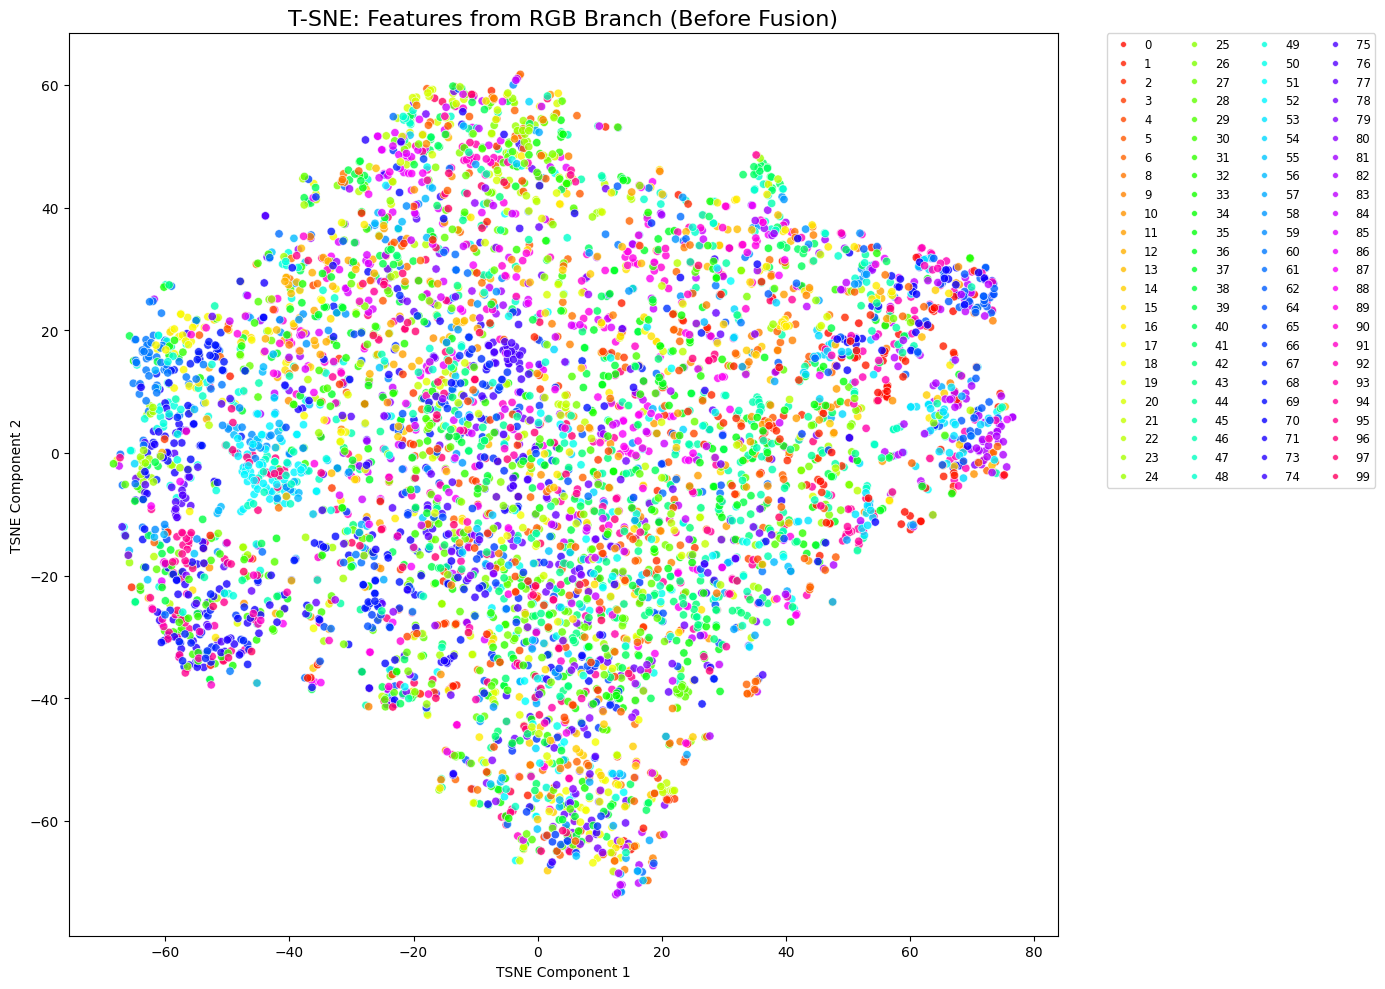

/tmp/ipykernel_1933229/977395255.py:110: UserWarning: The palette list has more values (100) than needed (96), which may not be intended.
  sns.scatterplot(


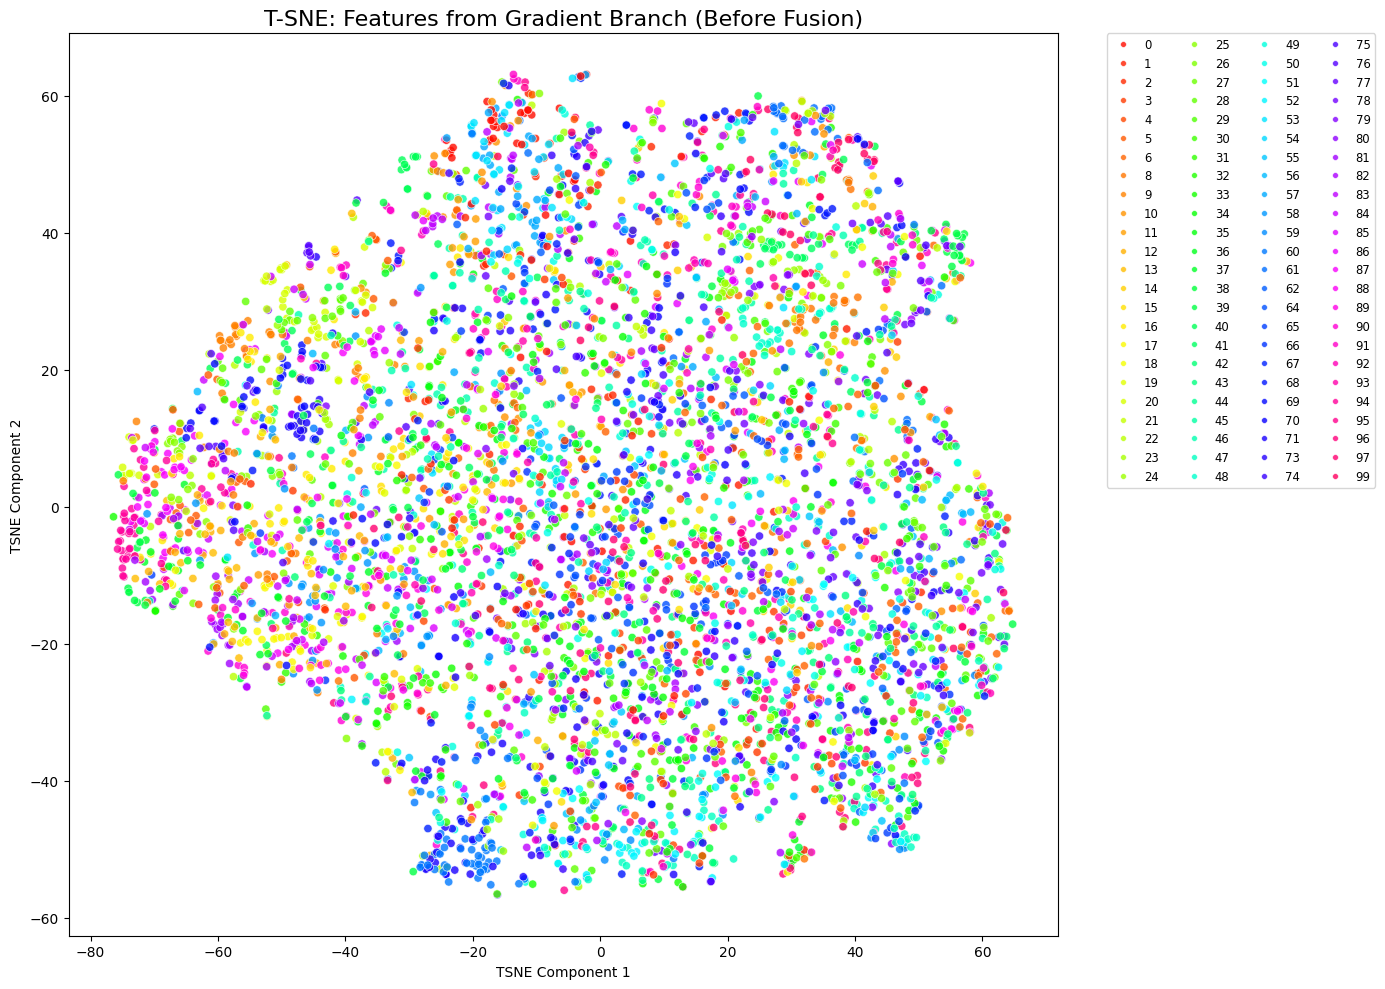

/tmp/ipykernel_1933229/977395255.py:110: UserWarning: The palette list has more values (100) than needed (96), which may not be intended.
  sns.scatterplot(


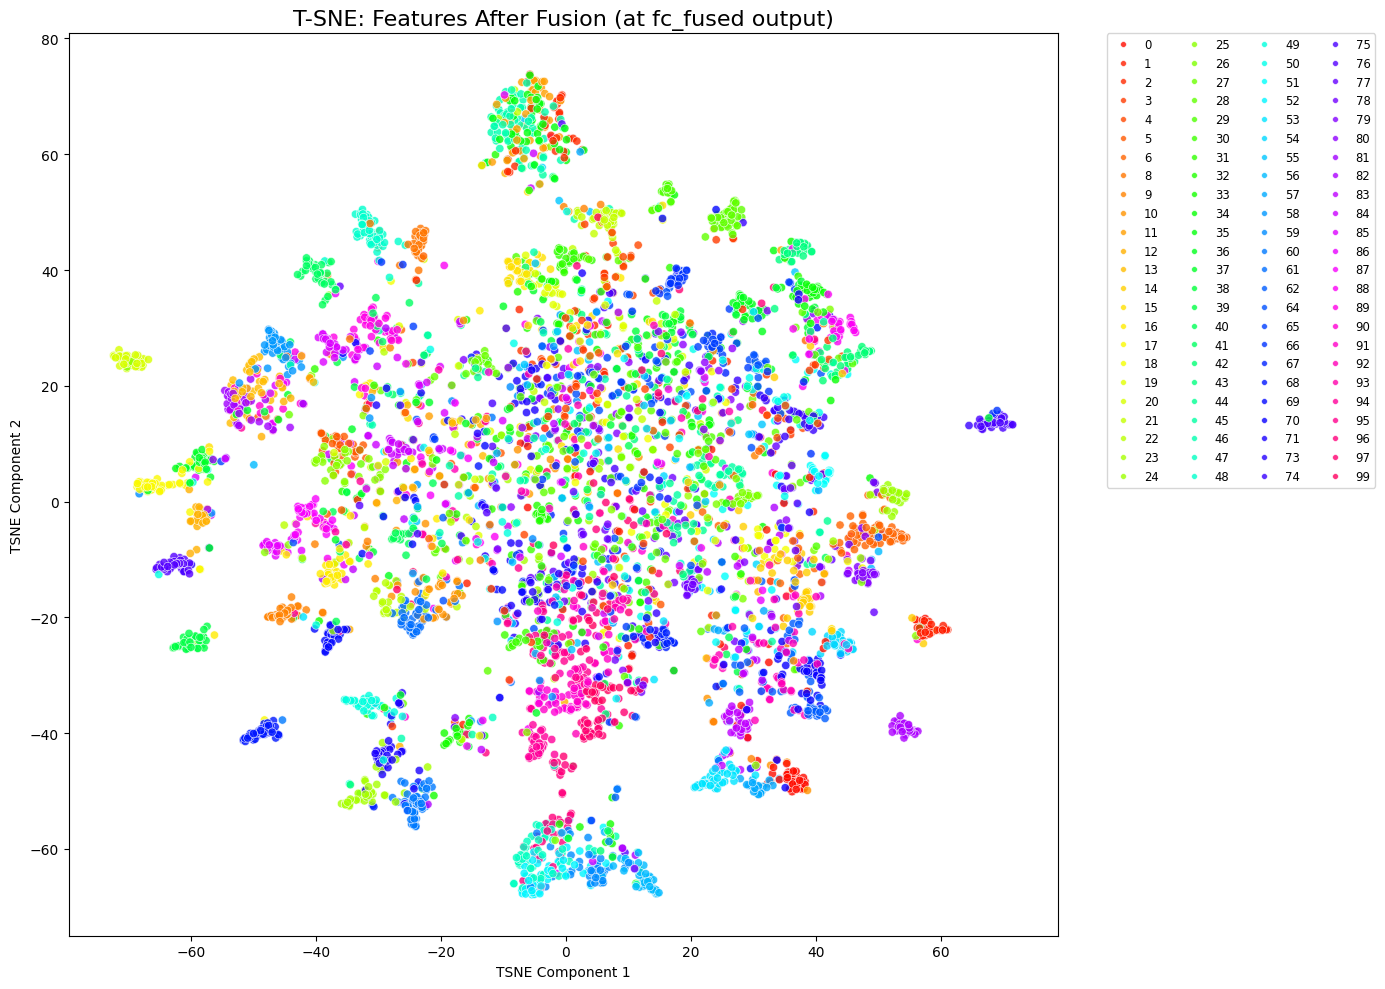

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch.nn.functional as F

# 1. 设置模型为评估模式
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# 2. 准备用于存储特征和标签的列表
features = {
    'rgb_branch': [],
    'grad_branch': [],
    'after_fusion': []
}
all_labels = []

# 3. 定义 PyTorch Hooks
def pool_and_flatten(module_output):
    # 'output' 形状是 [B, C, H, W]
    # 我们需要将其池化为 [B, C]
    pooled = F.adaptive_avg_pool2d(module_output, (1, 1))
    flattened = torch.flatten(pooled, 1)
    return flattened.detach().cpu().numpy()

def hook_rgb(module, input, output):
    # "Before" - RGB 分支 (在 layer3_rgb 之后, 融合之前)
    # output shape: [B, 256, H, W]
    features['rgb_branch'].append(pool_and_flatten(output))

def hook_grad(module, input, output):
    # "Before" - Gradient 分支 (在 layer3_grad 之后, 融合之前)
    # output shape: [B, 256, H, W]
    features['grad_branch'].append(pool_and_flatten(output))

def hook_after(module, input, output):
    # "After" - 融合后 (在 fc_fused 之后)
    # output shape: [B, 512]
    features['after_fusion'].append(output.detach().cpu().numpy())

# 4. 注册 hooks
# 钩子 1: 挂在 'layer3_rgb' 上, 捕获其输出
hook_handle_rgb = net.layer3_rgb.register_forward_hook(hook_rgb)
# 钩子 2: 挂在 'layer3_grad' 上, 捕获其输出
hook_handle_grad = net.layer3_grad.register_forward_hook(hook_grad)
# 钩子 3: 挂在 'fc_fused' 上, 捕获其输出 (融合后)
hook_handle_after = net.fc_fused.register_forward_hook(hook_after)

# 5. 遍历 test_loader 以捕获特征
print(f"Extracting features from test_loader...")
with torch.no_grad():
    for i, (img_rgb, img_grad, target) in enumerate(test_loader):
        img_rgb = img_rgb.to(device)
        img_grad = img_grad.to(device)
        target = target.to(device)
        
        # 运行前向传播以触发 hooks
        _ = net(img_rgb, img_grad)
        
        # 保存标签
        all_labels.append(target.cpu().numpy())
        
        # 为了节省时间，可以只运行几个 batch (例如 20-30 个)
        if i > 20: 
             print(f"Extracted features from {i+1} batches.")
             break

# 6. 移除 hooks
hook_handle_rgb.remove()
hook_handle_grad.remove()
hook_handle_after.remove()
print("Feature extraction complete. Hooks removed.")

# 7. 整理收集到的特征和标签
features_rgb = np.concatenate(features['rgb_branch'], axis=0)
features_grad = np.concatenate(features['grad_branch'], axis=0)
features_after = np.concatenate(features['after_fusion'], axis=0)
labels_arr = np.concatenate(all_labels, axis=0)

print(f"Total features extracted: {features_rgb.shape[0]}")
# 注意：此时 features_rgb 和 features_grad 是 [N, 256]
# features_after 是 [N, 512]
# T-SNE 对维度不同没有问题

# 8. (可选) 采样：T-SNE 在大数据集上很慢，我们只取 N 个样本进行可视化
# 由于我们上面只迭代了 20 个 batch，样本量应该足够小了
tsne_features_rgb = features_rgb
tsne_features_grad = features_grad
tsne_features_after = features_after
tsne_labels = labels_arr

# 9. 运行 T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)

print("Running T-SNE for 'RGB Branch (Before)' features...")
tsne_results_rgb = tsne.fit_transform(tsne_features_rgb)

print("Running T-SNE for 'Gradient Branch (Before)' features...")
tsne_results_grad = tsne.fit_transform(tsne_features_grad)

print("Running T-SNE for 'After Fusion' features...")
tsne_results_after = tsne.fit_transform(tsne_features_after)

print("T-SNE computation complete.")

# 10. 定义绘图函数
def plot_tsne(tsne_results, labels, title):
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        x=tsne_results[:, 0], 
        y=tsne_results[:, 1],
        hue=labels,
        palette=sns.color_palette("hsv", n_colors=100), # CIFAR-100
        legend="full",
        alpha=0.8
    )
    plt.title(title, fontsize=16)
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    # 将图例移到图表外部
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=0.7, fontsize='small', ncol=4)
    plt.tight_layout()
    # 保存图像以便在 notebook 中显示
    # plt.savefig(title.replace(" ", "_") + ".png") 
    plt.show() # 在 .ipynb 中, plt.show() 会直接显示图像

# 11. 绘制三个 T-SNE 图
plot_tsne(tsne_results_rgb, tsne_labels, "T-SNE: Features from RGB Branch (Before Fusion)")
plot_tsne(tsne_results_grad, tsne_labels, "T-SNE: Features from Gradient Branch (Before Fusion)")
plot_tsne(tsne_results_after, tsne_labels, "T-SNE: Features After Fusion (at fc_fused output)")